![](https://www.insurancejournal.com/app/uploads/2020/01/australia-wildlife-decimated-by-bushfires.jpg)
# Introduction
The purpose of this project is to identify the underlying cause of wildfire using the data from this massive database. This is my first kernel working on SQLite and I am excited to try this out!


## Let's import the required packages

In [145]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

188-million-us-wildfires



## Import the file using sqlite3.connect and the correct pathway to the file

In [146]:
file = sqlite3.connect('../input/188-million-us-wildfires/FPA_FOD_20170508.sqlite')

In [147]:
data = pd.read_sql_query("SELECT * FROM fires", con= file)

## Let's have an overview of the data

In [148]:
data.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE
count,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,9.889340e+05,988934.000000,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06
mean,9.402330e+05,5.484020e+07,2.003710e+03,2.453064e+06,1.647191e+02,5.979037e+00,2.453238e+06,172.656766,7.452016e+01,3.678121e+01,-9.570494e+01,1.059658e+01
std,5.428436e+05,1.011963e+08,6.663099e+00,2.434573e+03,9.003891e+01,3.483860e+00,2.687548e+03,84.320348,2.497598e+03,6.139031e+00,1.671694e+01,4.404662e+00
min,1.000000e+00,1.000000e+00,1.992000e+03,2.448622e+06,1.000000e+00,1.000000e+00,2.448622e+06,1.000000,1.000000e-05,1.793972e+01,-1.788026e+02,0.000000e+00
25%,4.701170e+05,5.055000e+05,1.998000e+03,2.451084e+06,8.900000e+01,3.000000e+00,2.450701e+06,102.000000,1.000000e-01,3.281860e+01,-1.103635e+02,8.000000e+00
50%,9.402330e+05,1.067761e+06,2.004000e+03,2.453178e+06,1.640000e+02,5.000000e+00,2.453466e+06,181.000000,1.000000e+00,3.545250e+01,-9.204304e+01,1.400000e+01
75%,1.410349e+06,1.910639e+07,2.009000e+03,2.455036e+06,2.300000e+02,9.000000e+00,2.455754e+06,232.000000,3.300000e+00,4.082720e+01,-8.229760e+01,1.400000e+01
max,1.880465e+06,3.003484e+08,2.015000e+03,2.457388e+06,3.660000e+02,1.300000e+01,2.457392e+06,366.000000,6.069450e+05,7.033060e+01,-6.525694e+01,1.500000e+01


### We can see that the dates are all in Julian format. We may need to change that.

In [149]:
data['DATE'] = pd.to_datetime(data['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(data.head())

   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ...   LATITUDE  \
0                  0511     Plumas National Forest  ...  40.0369

### We will then convert the date to day of week (Mon, Tue, etc) and month of year (Jan, Feb, etc).

In [150]:
# Converting to day of week
data['day_of_week'] = data['DATE'].dt.day_name()
print(data['day_of_week'])

# Converting to month of year
data['month'] = pd.DatetimeIndex(data['DATE']).month
data['month'] = data.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(data['month'])

0          Wednesday
1          Wednesday
2             Monday
3             Monday
4             Monday
             ...    
1880460     Saturday
1880461       Monday
1880462     Saturday
1880463    Wednesday
1880464     Saturday
Name: day_of_week, Length: 1880465, dtype: object
0          Feb
1          May
2          May
3          Jun
4          Jun
          ... 
1880460    Sep
1880461    Oct
1880462    May
1880463    Oct
1880464    Mar
Name: month, Length: 1880465, dtype: object


### Let's look into our columns and see which variables we will need for our analysis.

In [151]:
for col in data.columns:
    print(col)

OBJECTID
FOD_ID
FPA_ID
SOURCE_SYSTEM_TYPE
SOURCE_SYSTEM
NWCG_REPORTING_AGENCY
NWCG_REPORTING_UNIT_ID
NWCG_REPORTING_UNIT_NAME
SOURCE_REPORTING_UNIT
SOURCE_REPORTING_UNIT_NAME
LOCAL_FIRE_REPORT_ID
LOCAL_INCIDENT_ID
FIRE_CODE
FIRE_NAME
ICS_209_INCIDENT_NUMBER
ICS_209_NAME
MTBS_ID
MTBS_FIRE_NAME
COMPLEX_NAME
FIRE_YEAR
DISCOVERY_DATE
DISCOVERY_DOY
DISCOVERY_TIME
STAT_CAUSE_CODE
STAT_CAUSE_DESCR
CONT_DATE
CONT_DOY
CONT_TIME
FIRE_SIZE
FIRE_SIZE_CLASS
LATITUDE
LONGITUDE
OWNER_CODE
OWNER_DESCR
STATE
COUNTY
FIPS_CODE
FIPS_NAME
Shape
DATE
day_of_week
month


### We will be needing the following columns:
- DATE
- day_of_week
- month
- FIRE_YEAR
- DISCOVERY_TIME
- STAT_CAUSE_DESCR
- STATE
- FIRE_SIZE

In [159]:
lst = ['DATE', 'day_of_week', 'month', 'FIRE_YEAR', 'DISCOVERY_TIME', 'STAT_CAUSE_DESCR', 'STATE', 'FIRE_SIZE']
data_final = data[lst]
data_final.head()

,DATE,day_of_week,month,FIRE_YEAR,DISCOVERY_TIME,STAT_CAUSE_DESCR,STATE,FIRE_SIZE
0,2005-02-02,Wednesday,Feb,2005,1300,Miscellaneous,CA,0.10
1,2004-05-12,Wednesday,May,2004,0845,Lightning,CA,0.25
2,2004-05-31,Monday,May,2004,1921,Debris Burning,CA,0.10
3,2004-06-28,Monday,Jun,2004,1600,Lightning,CA,0.10
4,2004-06-28,Monday,Jun,2004,1600,Lightning,CA,0.10


# Looking into day of week 

Text(0.5, 1.0, 'Graph showing number of wildfire per day of week')

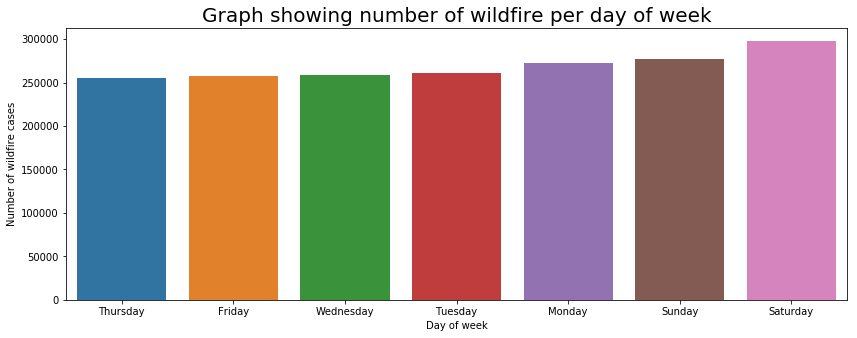

In [153]:
dow = data_final.groupby(['day_of_week']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = dow, y = 'count', x = 'day_of_week')
plt.xlabel('Day of week')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfire per day of week',fontsize=20)

## What do we see here
- It seems that the amount of wildfire cases is consistent from Tuesday to Friday, with significantly high cases from Saturday to Monday.
- Majority of these cases are caused by severe weather conditions and how I will explain the high number of cases over the weekends is that there are less fire regulations on work sites and this could result in the occurance of wildfire if equipments and flammable materials are not kept in proper conditions. 
- But could it be also due to deliberate actions like arson?

Text(0.5, 1.0, 'Graph showing number of wildfire per day of week caused by arson')

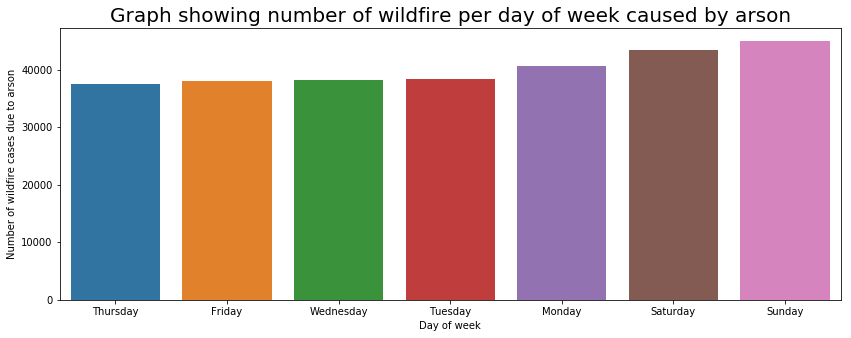

In [154]:
arson_data_per_day = data[data['STAT_CAUSE_DESCR'] == 'Arson'].groupby(['day_of_week']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = arson_data_per_day, y = 'count', x = 'day_of_week')
plt.xlabel('Day of week')
plt.ylabel('Number of wildfire cases due to arson')
g.axes.set_title('Graph showing number of wildfire per day of week caused by arson',fontsize=20)

### Well, it seems there are significantly higher cases of arson over the weekends. That could explain why we observe high trends on Saturdays and Sundays.

# Looking into month of year

Text(0.5, 1.0, 'Graph showing number of wildfire per month')

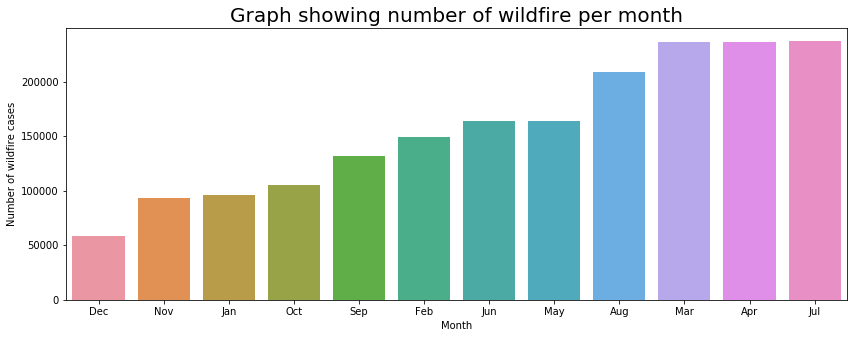

In [155]:
month_data = data_final.groupby(['month']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = month_data, y = 'count', x = 'month')
plt.xlabel('Month')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfire per month',fontsize=20)

## What do we see here?
- We observe high occurence of wildfires on March, April and July. 
- In US, with snow melting and the warmer temperatures rolling in, grass and other vegetation will become dry across the plains. These dry vegetation are highly flammable.
- This is the most dangerous time of the year because the grass is dead and dry, and the fresh green grass has yet to come in. Not only is it getting warmer and drier, but the winds are picking up which makes the spread of these fires rapid.

# Looking into year

Text(0.5, 1.0, 'Graph showing number of wildfire per year')

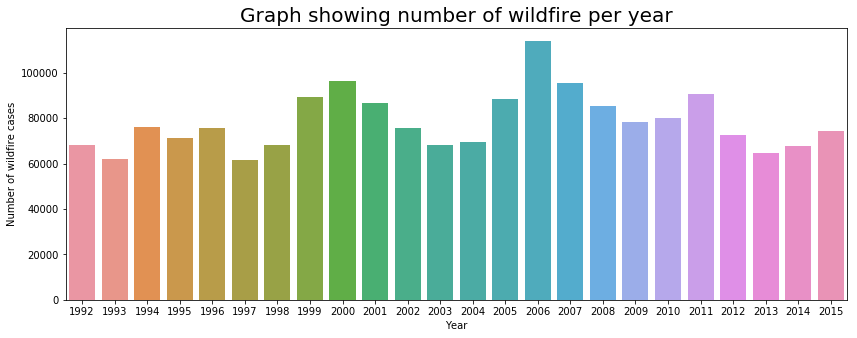

In [156]:
year_data = data_final.groupby(['FIRE_YEAR']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = year_data, y = 'count', x = 'FIRE_YEAR')
plt.xlabel('Year')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfire per year',fontsize=20)

### Let's understand the leading cause for the high number of wildfire on 2006

Text(0.5, 1.0, 'Graph showing cause of wildfire in 2006')

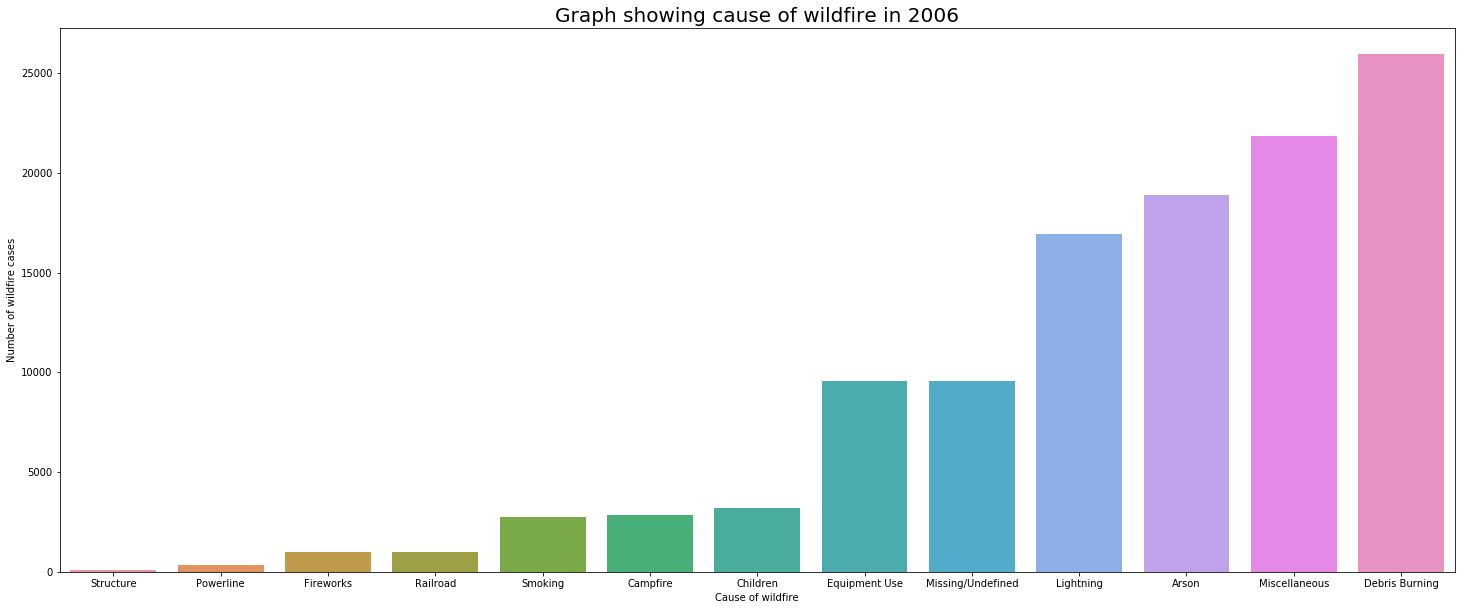

In [157]:
data_2006 = data[data['FIRE_YEAR'] == 2006].groupby(['STAT_CAUSE_DESCR']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(25,10))
g = sns.barplot(data = data_2006, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Cause of wildfire')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing cause of wildfire in 2006',fontsize=20)

## What do we see here?
- The main cause of wildfire in 2006 was due to debris burning. Debris buring is a cost-effective to get rid of yard waste and without a good knowledge of the weather condition, it may lead to severe wildfires. 

# Looking into number of wildfires by hour

In [162]:
data_final['new_time'] = data_final['DISCOVERY_TIME'].astype(str).str[:2]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,DATE,day_of_week,month,FIRE_YEAR,DISCOVERY_TIME,STAT_CAUSE_DESCR,STATE,FIRE_SIZE,new_time
0,2005-02-02,Wednesday,Feb,2005,1300,Miscellaneous,CA,0.10,13
1,2004-05-12,Wednesday,May,2004,0845,Lightning,CA,0.25,08
2,2004-05-31,Monday,May,2004,1921,Debris Burning,CA,0.10,19
3,2004-06-28,Monday,Jun,2004,1600,Lightning,CA,0.10,16
4,2004-06-28,Monday,Jun,2004,1600,Lightning,CA,0.10,16
...,...,...,...,...,...,...,...,...,...
1880460,2015-09-26,Saturday,Sep,2015,1726,Missing/Undefined,CA,0.01,17
1880461,2015-10-05,Monday,Oct,2015,0126,Miscellaneous,CA,0.20,01
1880462,2015-05-02,Saturday,May,2015,2052,Missing/Undefined,CA,0.10,20
1880463,2015-10-14,Wednesday,Oct,2015,2309,Missing/Undefined,CA,2.00,23


Text(0.5, 1.0, 'Graph showing number of wildfire per hour in a day')

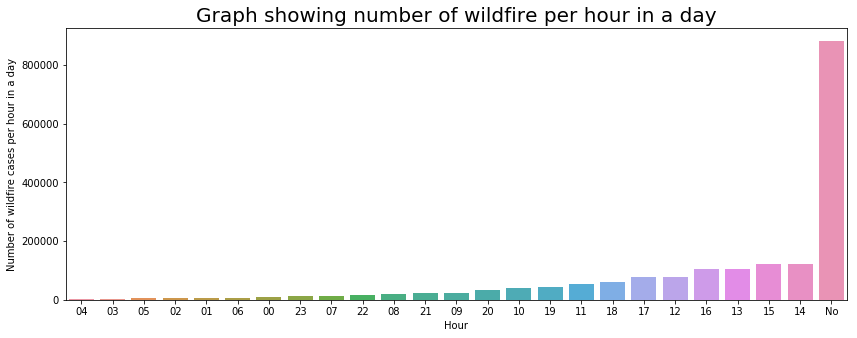

In [163]:
hour_data = data_final.groupby(['new_time']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(14,5))
g = sns.barplot(data = hour_data, y = 'count', x = 'new_time')
plt.xlabel('Hour')
plt.ylabel('Number of wildfire cases per hour in a day')
g.axes.set_title('Graph showing number of wildfire per hour in a day',fontsize=20)

## What do we see here?
- Majority of the wildfire occurs in daytime, between 12PM to 4PM. This is also the period where the sun is the strongest.

# Looking into what are the main causes for wildfire

Text(0.5, 1.0, 'Graph showing number of wildfire per cause')

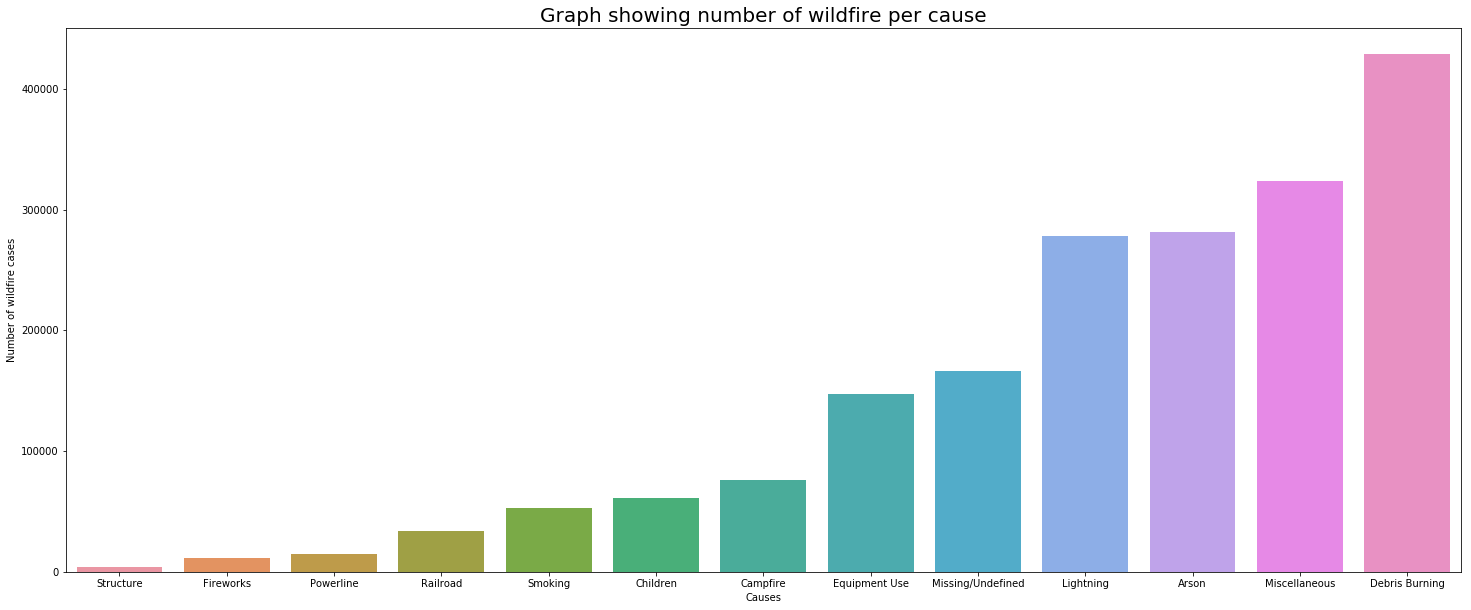

In [165]:
cause_data = data_final.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(25,10))
g = sns.barplot(data = cause_data, y = 'count', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Causes')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfire per cause',fontsize=20)

## What do we see here?
- It seems that debris burning is the main cause for wildfire. 
- The government should spend more effort in educating their citizens with regards to debris burning (applying for license, when to burn and how to burn to ensure fire does not become uncontrollable).

### So what are the impact of each causes?

Text(0.5, 1.0, 'Graph showing size of wildfire per cause')

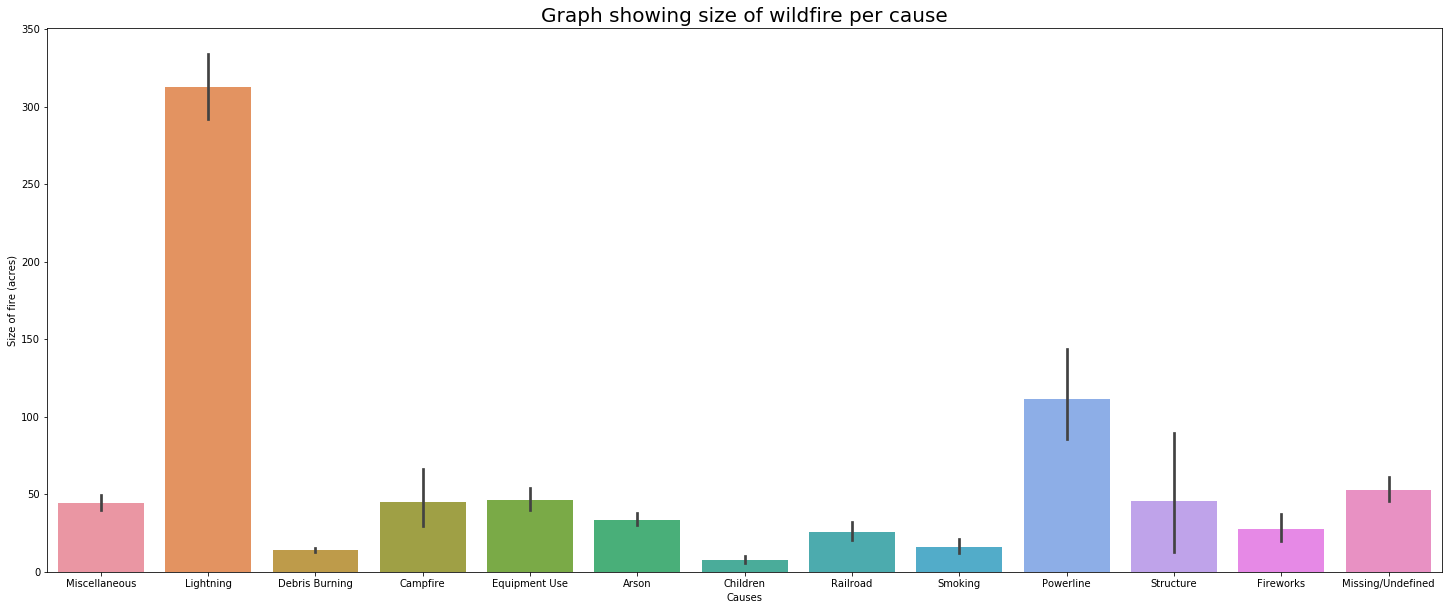

In [179]:
# Creating barplot
plt.figure(figsize=(25,10))
g = sns.barplot(data = data_final, y = 'FIRE_SIZE', x = 'STAT_CAUSE_DESCR')
plt.xlabel('Causes')
plt.ylabel('Size of fire (acres)')
g.axes.set_title('Graph showing size of wildfire per cause',fontsize=20)

## What do we see here?
- Weird enough, it seems that lightning causes damages to more acres of land than debris burning. 
- The increase in number of dry thunderstorms during dry season could be the reason for the slowdown in firefighting, resulting in more acres of land being burned. 

# Looking into states affected by wildfires

Text(0.5, 1.0, 'Graph showing number of wildfire per state')

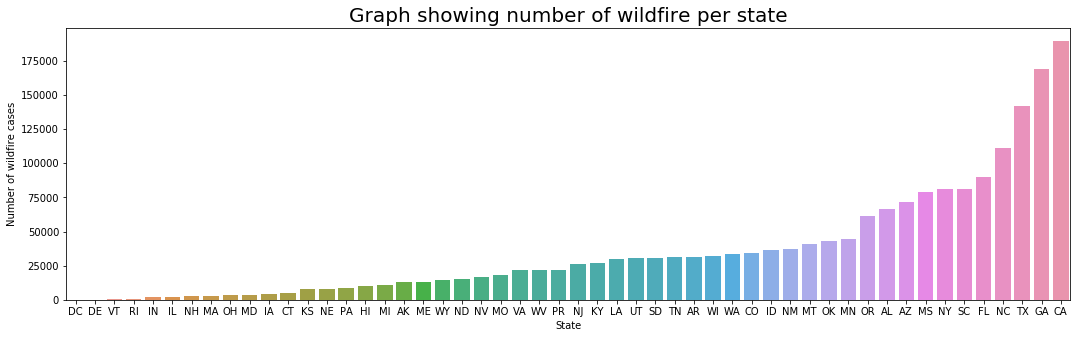

In [168]:
state_data = data_final.groupby(['STATE']).size().reset_index(name = 'count').sort_values('count')

# Creating barplot
plt.figure(figsize=(18,5))
g = sns.barplot(data = state_data, y = 'count', x = 'STATE')
plt.xlabel('State')
plt.ylabel('Number of wildfire cases')
g.axes.set_title('Graph showing number of wildfire per state',fontsize=20)

## What do we see here?
- It seems that California, Georgia and Texas have the highest number of wildfire cases. 
- An edition of [nationalgeographic](https://www.nationalgeographic.com/science/2019/10/climate-change-california-power-outage/) has stated that California is affected heavily by climate changes. With an increase in temperature of over 3 Fahrenheit, water have been drawn out from the soil and leaves, leaving a dry and warm condition susceptible to burning.
- The strong winds around the area also speed up the rate of burning.

# Summary
- Majority of the wildfires occurred over the weekends and after looking into the data, we realise that there is an increase in arson during that period. 
- Majority of the wildfires were caused by debris burning. Hence, proper education is needed in this area to reduce wildfires.
- Lightning destroyed the most arces of land.
- California, Georgia and Texas are the top 3 states for wildfire cases.